# bibliotecas utilizadas

In [11]:
# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.integrate import simps
from scipy.signal import gaussian

from core.evolution import imaginary
from core.empirical import in_segregation

au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## função que gera o perfil de concentração

In [12]:
def concentration(x0, R, ml):
    # 2 monolayers requires 100 surrounding
    # 20 monolayers requires 10 surrounding
    # but let's force at least 10
    nsl = max(10,int(110+(10-100/(20-2))*ml)) # number of surrounding layers (each side)
    
    tl = ml + 2 * nsl  # total layers
    # bulk before well
    x = [0] * nsl
    # well
    for n in range(1, ml+1):
        x.append(in_segregation(x0, R, n))
    # barrier after well
    for n in range(1, nsl+1):
        x.append(in_segregation(x0, R, n+ml, ml))
    return np.arange(1, len(x)+1), np.array(x)

## parâmetros buscados

In [13]:
x0     = 0.16 # intended indium concentration
R      = 0.85 # segregation parameter
N      = 1024 # number of grid points
offset = (0.7, 0.3)

# number of layers
ml_grid = range(2,30)

# for ml in ml_grid:
#     layers, in_x = concentration(x0, R, ml)
#     plt.scatter(layers, in_x, label="Monolayers: %d" % ml)

# plt.xlabel('$x_0$ (In concentration)')
# plt.xlabel('z (\AA)')
# plt.legend()
# plt.plot()

## parâmetros de acordo com Martini

In [14]:
a0   = np.vectorize(lambda x:  6.08 *x+(1-x)*  5.650)
a    = np.vectorize(lambda x: -6.08 *x+(1-x)* -8.33 )
b    = np.vectorize(lambda x: -1.55 *x+(1-x)* -1.90 )
c11  = np.vectorize(lambda x:  0.83 *x+(1-x)*  1.22 )
c12  = np.vectorize(lambda x:  0.45 *x+(1-x)*  0.57 )

me   = np.vectorize(lambda x: 0.067*(1-0.426*x))
mhhz = np.vectorize(lambda x: 0.34 *(1+0.117*x))

## cálculo de acordo com o número de monolayers

In [15]:
PL_nosso = []
infos_e = []
infos_h = []

for ml in ml_grid:
    layers, in_x = concentration(x0, R, ml)

    def concentration_z(z):
        position = 0.0
        for x, a in zip(in_x, a0(in_x)):
            position += a/2.0
            if z < position:
                return x
        return in_x[0]

    z      = np.linspace(0.0, np.sum(a0(in_x))/2.0, N)
    in_x_z = np.vectorize(concentration_z)(z)
    gap    = np.vectorize(lambda x: 1.5192-1.5837*x+0.475*x**2)(in_x_z)

    _a   = a(in_x_z)
    _b   = b(in_x_z)
    _c11 = c11(in_x_z)
    _c12 = c12(in_x_z)
    _epp = (a0([0])[0]-a0(in_x_z))/a0(in_x_z)

    gap_strain = gap + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
    gap_c      = offset[0] * gap_strain
    gap_v      = offset[1] * gap_strain

    z_au    = z/au2ang # angstrom to au
    v_e_au  = (gap_c-np.min(gap_c))/au2ev # eV to au
    v_hh_au = (gap_v-np.min(gap_v))/au2ev # eV to au
    
    # imaginary evolution
    #electron   = imaginary(z_au,v_e_au,np.min(me(in_x_z)))
    #heavy_hole = imaginary(z_au,v_hh_au,np.min(mhhz(in_x_z)))
    
    electron   = imaginary(z_au,v_e_au ,  me(in_x_z))
    infos_e.append(electron)
    heavy_hole = imaginary(z_au,v_hh_au, mhhz(in_x_z))
    infos_h.append(heavy_hole)
    
    Ee      = electron['eigenvalues'][0]* au2ev
    Ce      = electron['counters'][0]
    Pe      = electron['precisions'][0]
    Te      = electron['timers'][0]
    Se      = electron['squared_euclidean_dist'][0]
    Ee_es   = electron['eigenstates'][0]
    
    Ehh     = heavy_hole['eigenvalues'][0]* au2ev
    Chh     = heavy_hole['counters'][0]
    Phh     = heavy_hole['precisions'][0]
    Thh     = heavy_hole['timers'][0]
    Shh     = heavy_hole['squared_euclidean_dist'][0]
    Ehh_es  = heavy_hole['eigenstates'][0]
    
#     envelope  = Ee_es + Ehh_es
#     envelope  = envelope  / np.sqrt(simps(envelope.conj()*envelope, z))
#     z_med     = simps(envelope.conj()*z*envelope,z)
    
#     Ee_es  = Ee_es   / np.sqrt(simps(Ee_es.conj()  * Ee_es  , z))
#     Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
#     z_med  = simps(Ehh_es.conj()*z*Ee_es,z)

#     Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
#     z_med  = simps(Ehh_es.conj()*z*Ehh_es,z)/simps(Ehh_es.conj()*Ehh_es,z)
#     idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
#     gap_min = gap_strain[idx]
    
    gap_min = np.min(gap_strain)
    pl = gap_min+Ehh+Ee-7e-3
    PL_nosso.append(pl)
    
    print("ML={0:02d}, Ee={1:.8f}, Te={2:04.1f} s, Ehh={3:.8f}, Thh={4:04.1f} s, PL={5:.8f} eV".format(
        ml, Ee, Te, Ehh, Thh, pl))

ML=02, Ee=0.03447683, Te=84.1 s, Ehh=0.01411659, Thh=109.9 s, PL=1.50851478 eV
ML=03, Ee=0.04653362, Te=55.8 s, Ehh=0.01861464, Thh=74.8 s, PL=1.50490525 eV
ML=04, Ee=0.05566349, Te=38.3 s, Ehh=0.02180165, Thh=57.4 s, PL=1.50019440 eV
ML=05, Ee=0.06266059, Te=29.6 s, Ehh=0.02412229, Thh=46.7 s, PL=1.49511967 eV
ML=06, Ee=0.06778051, Te=24.8 s, Ehh=0.02563432, Thh=40.8 s, PL=1.48957673 eV
ML=07, Ee=0.07126789, Te=21.5 s, Ehh=0.02649733, Thh=36.1 s, PL=1.48362096 eV
ML=08, Ee=0.07335826, Te=18.8 s, Ehh=0.02675925, Thh=33.1 s, PL=1.47724375 eV
ML=09, Ee=0.07469861, Te=17.1 s, Ehh=0.02684130, Thh=30.8 s, PL=1.47126830 eV
ML=10, Ee=0.07510392, Te=15.8 s, Ehh=0.02656107, Thh=29.2 s, PL=1.46512130 eV
ML=11, Ee=0.07491576, Te=15.1 s, Ehh=0.02609597, Thh=28.1 s, PL=1.45914840 eV
ML=12, Ee=0.07452407, Te=14.2 s, Ehh=0.02564158, Thh=27.3 s, PL=1.45378902 eV
ML=13, Ee=0.07289763, Te=13.4 s, Ehh=0.02464103, Thh=26.8 s, PL=1.44733181 eV
ML=14, Ee=0.07138298, Te=13.0 s, Ehh=0.02380967, Thh=26.3 s, PL

## PL de acordo com Martini e Experimental

In [16]:
PL_martini      = [1.50208315, 1.48793928, 1.4578344 , 1.4343612 , 1.41212442]
PL_experimental = [1.50498686, 1.49103033, 1.46214312, 1.43623456, 1.41525293]

## comparação

[]

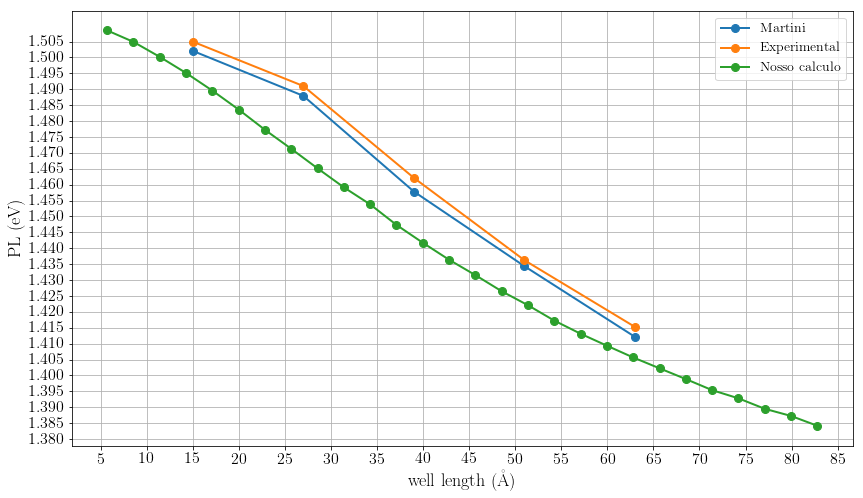

In [17]:
wl = [15, 27, 39, 51, 63]

fig = plt.figure()
ax  = fig.gca()

ax.set_xticks(np.arange(0, 100.00, 5.000))
ax.set_yticks(np.arange(0,  1.51, 0.005))
ax.set_xlabel('well length (\AA)')
ax.set_ylabel('PL (eV)')

ax.plot(wl, PL_martini     , '-o', label='Martini')
ax.plot(wl, PL_experimental, '-o', label='Experimental')
ax.plot([float(i)*5.71/2 for i in range(2,30)], PL_nosso       , '-o', label='Nosso calculo')

plt.legend()
plt.grid(True)
plt.plot()

In [32]:
PL_nosso_roubado = []
for ml, electron, heavy_hole in zip(ml_grid, infos_e, infos_h):
    layers, in_x = concentration(x0, R, ml)

    def concentration_z(z):
        position = 0.0
        for x, a in zip(in_x, a0(in_x)):
            position += a/2.0
            if z < position:
                return x
        return in_x[0]

    z      = np.linspace(0.0, np.sum(a0(in_x))/2.0, N)
    in_x_z = np.vectorize(concentration_z)(z)
    gap    = np.vectorize(lambda x: 1.5192-1.5837*x+0.475*x**2)(in_x_z)

    _a   = a(in_x_z)
    _b   = b(in_x_z)
    _c11 = c11(in_x_z)
    _c12 = c12(in_x_z)
    _epp = (a0([0])[0]-a0(in_x_z))/a0(in_x_z)

    gap_strain = gap + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
    gap_c      = offset[0] * gap_strain
    gap_v      = offset[1] * gap_strain

    z_au    = z/au2ang # angstrom to au
    v_e_au  = (gap_c-np.min(gap_c))/au2ev # eV to au
    v_hh_au = (gap_v-np.min(gap_v))/au2ev # eV to au
    
    # imaginary evolution
    #electron   = imaginary(z_au,v_e_au,np.min(me(in_x_z)))
    #heavy_hole = imaginary(z_au,v_hh_au,np.min(mhhz(in_x_z)))
    
    Ee      = electron['eigenvalues'][0]* au2ev
    Ce      = electron['counters'][0]
    Pe      = electron['precisions'][0]
    Te      = electron['timers'][0]
    Se      = electron['squared_euclidean_dist'][0]
    Ee_es   = electron['eigenstates'][0]
    
    Ehh     = heavy_hole['eigenvalues'][0]* au2ev
    Chh     = heavy_hole['counters'][0]
    Phh     = heavy_hole['precisions'][0]
    Thh     = heavy_hole['timers'][0]
    Shh     = heavy_hole['squared_euclidean_dist'][0]
    Ehh_es  = heavy_hole['eigenstates'][0]
    
#     envelope  = Ee_es + Ehh_es
#     envelope  = envelope  / np.sqrt(simps(envelope.conj()*envelope, z))
#     z_med     = simps(envelope.conj()*z*envelope,z)
    
#     Ee_es  = Ee_es   / np.sqrt(simps(Ee_es.conj()  * Ee_es  , z))
#     Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
#     z_med  = simps(Ehh_es.conj()*z*Ee_es,z)/simps(Ehh_es.conj()*Ee_es,z)
    
    Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
    z_med  = simps(Ehh_es.conj()*z*Ehh_es,z)/simps(Ehh_es.conj()*Ehh_es,z)
    
    idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
    gap_min = gap_strain[idx]
    #gap_min = np.min(gap_strain)
    pl = gap_min+Ehh+Ee-7e-3
    PL_nosso_roubado.append(pl)
    
    print("ML={0:02d}, Ee={1:.8f}, Te={2:04.1f} s, Ehh={3:.8f}, Thh={4:04.1f} s, PL={5:.8f} eV".format(
        ml, Ee, Te, Ehh, Thh, pl))

ML=02, Ee=0.03447683, Te=84.1 s, Ehh=0.01411659, Thh=109.9 s, PL=1.53338785 eV
ML=03, Ee=0.04653362, Te=55.8 s, Ehh=0.01861464, Thh=74.8 s, PL=1.53264618 eV
ML=04, Ee=0.05566349, Te=38.3 s, Ehh=0.02180165, Thh=57.4 s, PL=1.53439165 eV
ML=05, Ee=0.06266059, Te=29.6 s, Ehh=0.02412229, Thh=46.7 s, PL=1.52356607 eV
ML=06, Ee=0.06778051, Te=24.8 s, Ehh=0.02563432, Thh=40.8 s, PL=1.50668250 eV
ML=07, Ee=0.07126789, Te=21.5 s, Ehh=0.02649733, Thh=36.1 s, PL=1.50221538 eV
ML=08, Ee=0.07335826, Te=18.8 s, Ehh=0.02675925, Thh=33.1 s, PL=1.47724375 eV
ML=09, Ee=0.07469861, Te=17.1 s, Ehh=0.02684130, Thh=30.8 s, PL=1.47126830 eV
ML=10, Ee=0.07510392, Te=15.8 s, Ehh=0.02656107, Thh=29.2 s, PL=1.47139338 eV
ML=11, Ee=0.07491576, Te=15.1 s, Ehh=0.02609597, Thh=28.1 s, PL=1.46446804 eV
ML=12, Ee=0.07452407, Te=14.2 s, Ehh=0.02564158, Thh=27.3 s, PL=1.46362196 eV
ML=13, Ee=0.07289763, Te=13.4 s, Ehh=0.02464103, Thh=26.8 s, PL=1.45567532 eV
ML=14, Ee=0.07138298, Te=13.0 s, Ehh=0.02380967, Thh=26.3 s, PL

In [ ]:
[1.4888947  1.47994004 1.44912327 1.42298991 1.40406898]
[1.50208315 1.48793928 1.4578344  1.4343612  1.41212442]
[1.50498686 1.49103033 1.46214312 1.43623456 1.41525293]

In [19]:
infos_e = np.array(infos_e)
infos_h = np.array(infos_h)
np.savez('electron_info', infos_e)
np.savez('hole_info', infos_h)


[]

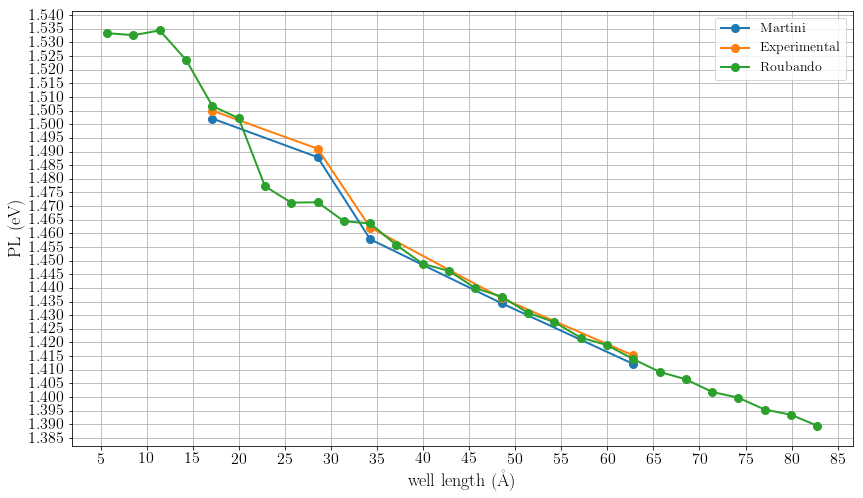

In [41]:
#wl = [15, 27, 39, 51, 63]
wl = np.array([6,10,12,17,22])*5.71/2

fig = plt.figure()
ax  = fig.gca()

ax.set_xticks(np.arange(0, 100.00, 5.000))
ax.set_yticks(np.arange(0,  1.61, 0.005))
ax.set_xlabel('well length (\AA)')
ax.set_ylabel('PL (eV)')

ax.plot(wl, PL_martini     , '-o', label='Martini')
ax.plot(wl, PL_experimental, '-o', label='Experimental')
#ax.plot([float(i)*5.71/2 for i in range(2,30)], PL_nosso       , '-o', label='Nosso calculo')
ax.plot([float(i)*5.71/2 for i in range(2,30)], PL_nosso_roubado       , '-o', label='Roubando')

plt.legend()
plt.grid(True)
plt.plot()

[]

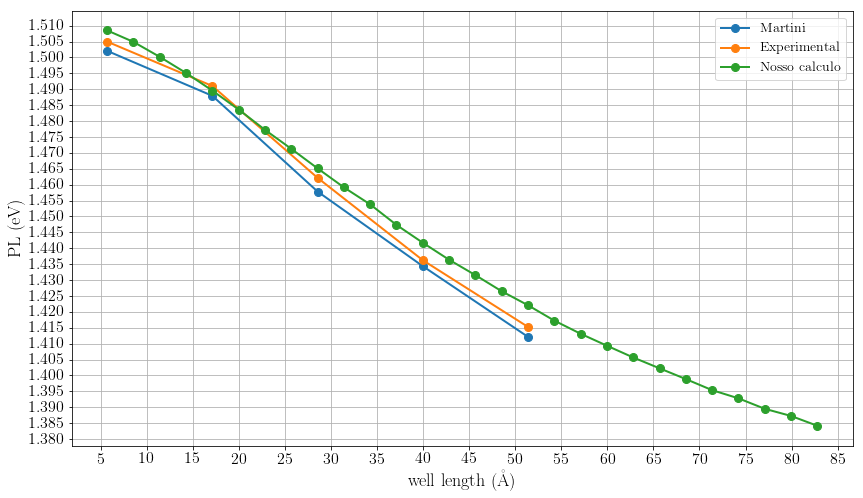

In [40]:
#wl = [15, 27, 39, 51, 63]
wl = np.array([2,6,10,14,18])*5.71/2

fig = plt.figure()
ax  = fig.gca()

ax.set_xticks(np.arange(0, 100.00, 5.000))
ax.set_yticks(np.arange(0,  1.61, 0.005))
ax.set_xlabel('well length (\AA)')
ax.set_ylabel('PL (eV)')

ax.plot(wl, PL_martini     , '-o', label='Martini')
ax.plot(wl, PL_experimental, '-o', label='Experimental')
ax.plot([float(i)*5.71/2 for i in range(2,30)], PL_nosso       , '-o', label='Nosso calculo')

plt.legend()
plt.grid(True)
plt.plot()